In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from model.source_identify_model import SourceIdentifyModel
from model.base_intensity import ConstantBaseIntensity
from model.kernels import ExponentialKernel
from model.impact_function import ConstantImpactFunction
from model.mark_density import SpatialMarkDensity

from collections import Counter
from sklearn.metrics import confusion_matrix

import seaborn as sns
sns.set_style('white')

In [4]:
# magics
%matplotlib inline
%load_ext autoreload
%autoreload 2

# test the univariate case

In [5]:
base_intensities = [ConstantBaseIntensity()] 
base_intensity_weights = [0.05] 
influential_matrix = 0.8
kernel = ExponentialKernel(1)
impact_function = ConstantImpactFunction()
mark_density = SpatialMarkDensity(1, 0, 1, 0.5)

In [6]:
model = SourceIdentifyModel(1, base_intensities=base_intensities,
                            base_intensity_weights=base_intensity_weights,
                            influential_matrix=influential_matrix,
                            kernel=kernel,
                            impact_function=impact_function,
                            mark_density=mark_density)

In [7]:
%%time

events, parents = model.simulate(10000, rand_state=0)
print len(events)

2808
CPU times: user 1.47 s, sys: 101 ms, total: 1.57 s
Wall time: 1.51 s


In [8]:
%%time
tau = model.cumulative_transform(events)

CPU times: user 69.1 ms, sys: 4.45 ms, total: 73.6 ms
Wall time: 71.3 ms


In [9]:
np.diff(tau)

array([ 1.73263235,  0.61884574,  3.0301256 , ...,  2.33028194,
        0.44018021,  0.18813172])

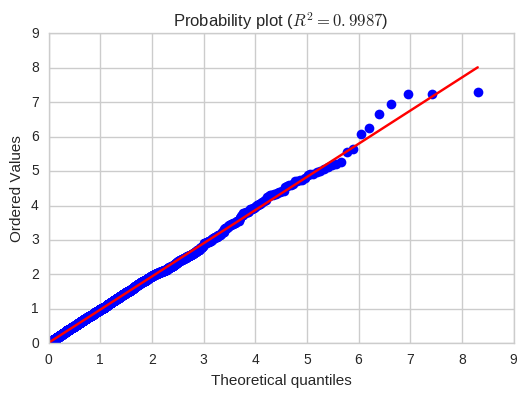

In [10]:
import scipy.stats as stats

_, results = stats.probplot(np.diff(tau), dist='expon', plot=plt)
plt.title("Probability plot ($R^2=%1.4f$)" % results[2] ** 2)

# Test the multivate case

In [11]:
n_dimensions = 3
t_max = 2000
base_intensities = [ConstantBaseIntensity()] * n_dimensions 
base_intensity_weights = [0.1, 0.1, 0.1] 
influential_matrix = np.array(
                      [[0.3, 0.1, 0.1], 
                       [0.1, 0.3, 0.1], 
                       [0.1, 0.1, 0.3]])

scale = 10.
kernel = ExponentialKernel(scale)
impact_function = ConstantImpactFunction()
p_dimensions = 2
eye = np.eye(p_dimensions)
mark_density = SpatialMarkDensity(p_dimensions, immigrant_means= [[-2, -2], [0, 0], [2, 2]], 
                                  immigrant_covars = [eye, eye, eye], 
                                  offspring_covars = [0.5 * eye, 0.5 * eye, 0.5 * eye])

In [12]:
model = SourceIdentifyModel(n_dimensions, base_intensities=base_intensities,
                            base_intensity_weights=base_intensity_weights,
                            influential_matrix=influential_matrix,
                            kernel=kernel,
                            impact_function=impact_function,
                            mark_density=mark_density)

In [13]:
%%time

events, parents = model.simulate(t_max, rand_state=0)
print "Generate %r events."  % len(events)

Generate 1180 events.
CPU times: user 1.03 s, sys: 55.3 ms, total: 1.09 s
Wall time: 1.04 s


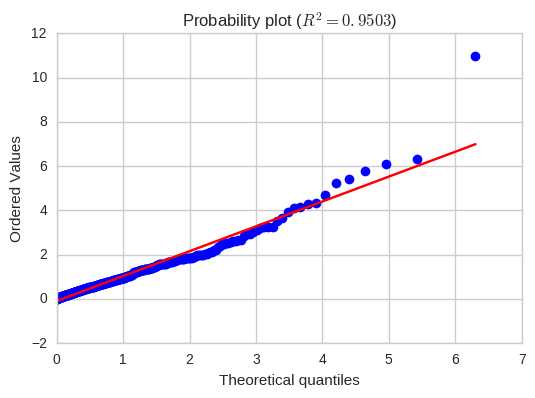

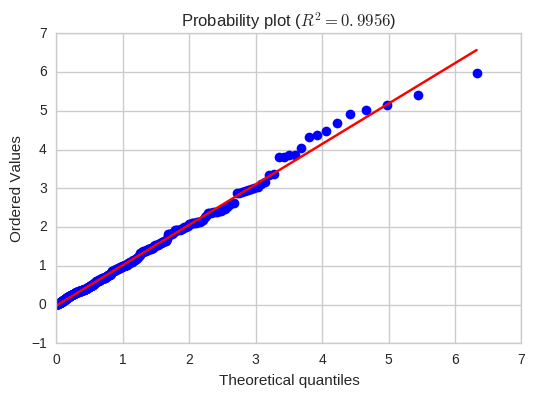

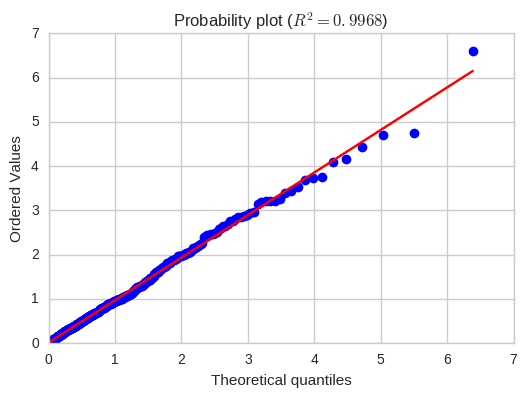

In [14]:
tau = model.cumulative_transform(events)

for i in range(n_dimensions):
    tau_i = [t for t, e in zip(tau, events) if e[1] == i]
    plt.figure()
    _, results = stats.probplot(np.diff(tau_i), dist='expon', plot=plt)
    plt.title("Probability plot ($R^2=%1.4f$)" % results[2] ** 2)

# explore the samples

In [15]:
def construct_dataframe(events, parents):
    df = pd.DataFrame()
    df['t'] = [e[0] for e in events]
    df['i'] = [e[1] for e in events]
    df['x1'] = [e[2][0] for e in events]
    df['x2'] = [e[2][1] for e in events]
    df['z'] = parents
    return df

df = construct_dataframe(events, parents)
df.head()

t  i        x1        x2  z
0   5.510485  2  3.266119  1.494123  0
1   6.211724  2  3.579977  1.730067  1
2   7.008557  2  2.033439  2.680567  0
3  11.197808  0 -0.467221 -0.530641  0
4  14.669911  1 -1.085801  0.639736  0

In [16]:
roots = model.eval_roots((e[1] for e in events), parents)

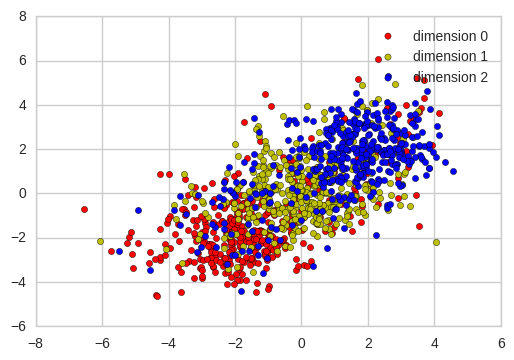

In [17]:
import seaborn
plt.figure()

colors = 'ryb'
markers = 'ooo'
for i in range(n_dimensions):    
    plt.scatter(df[df.i == i].x1, df[df.i == i].x2, 
                c=colors[i], marker=markers[i])

plt.legend(['dimension 0', 'dimension 1', 'dimension 2'])

## Explore the rooted probability

In [18]:
rooted_proba = model.eval_rooted_proba(events)

1180it [00:53, 19.83it/s]


In [51]:
def plot_ternary(root_proba, indeces, colors=['red','green','blue'],markers=['s','D','o'], fontsize = 20):
    assert (len(root_proba) == len(indeces)) & (np.size(root_proba) == 3*np.size(indeces))
    assert (min(np.reshape(root_proba,np.size(root_proba))) >= 0) & (max(np.reshape(root_proba,np.size(root_proba))) <= 1)
    for ind in indeces:
        if ind in [1,2,3]:
            pass
        else:
            raise IndexError('Index other than 1,2,3')
    
    import ternary
    figure, tax = ternary.figure(scale=1)
    figure.set_size_inches(10,10)
    tax.boundary(linewidth=2.0)
    tax.gridlines(color = 'blue', multiple=0.05, linewidth=0.5)
    tax.bottom_axis_label('$\\mu_1$',fontsize=fontsize, color='brown')
    tax.right_axis_label('$\\mu_2$', fontsize=fontsize, color='brown')
    tax.left_axis_label('$\\mu_3$', fontsize =fontsize, color='brown')
    
    # plot the prediction boundary
    p = (1./3,1./3,1./3); p1 = (0, 0.5, 0.5); p2 = (0.5, 0, 0.5); p3 = (0.5, 0.5, 0)
    tax.line(p, p1, linestyle='--', color = 'brown', linewidth=3)
    tax.line(p, p2, linestyle='--', color = 'brown', linewidth=3)
    tax.line(p, p3, linestyle='--', color = 'brown', linewidth=3)
 
    # plot scatter plot of the points
    for i in [1,2,3]:
        points = root_proba[indeces==i]
        if len(points) == 0:
            continue
        tax.scatter(points, linewidth=3.5, marker=markers[i-1],
                    color=colors[i-1], label='dimension ' + str(i))
    
    tax.ticks(axis = 'lbr', multiple = 0.1, linewidth = 1) 
    tax.legend()
    tax.clear_matplotlib_ticks()
    tax.show()
    
    return figure, tax

## rooted probability distribution v.s. sample roots

1053it [00:42, 28.04it/s]


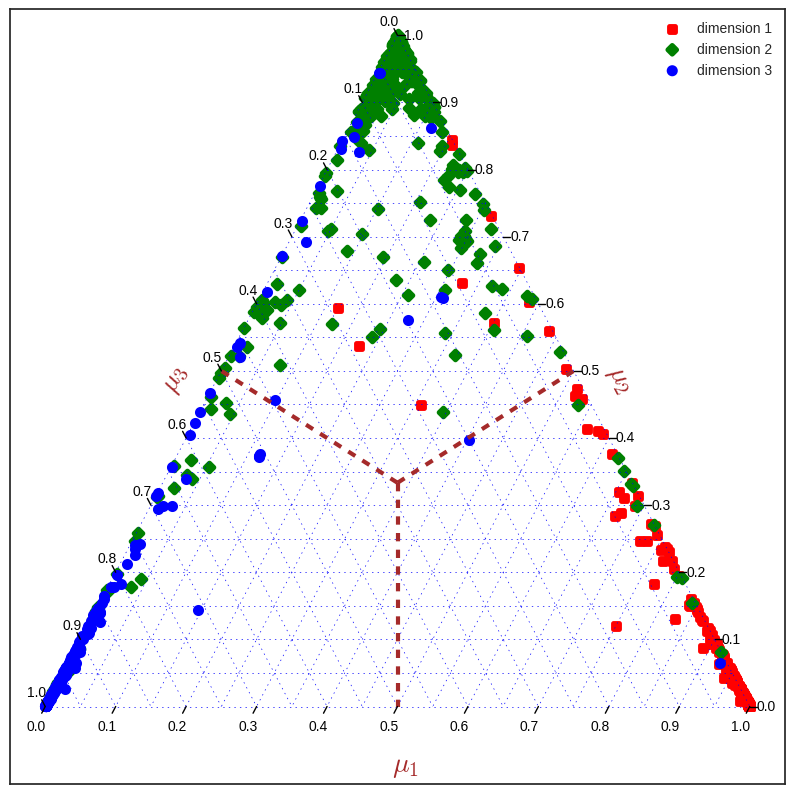

1261it [01:00, 20.98it/s]


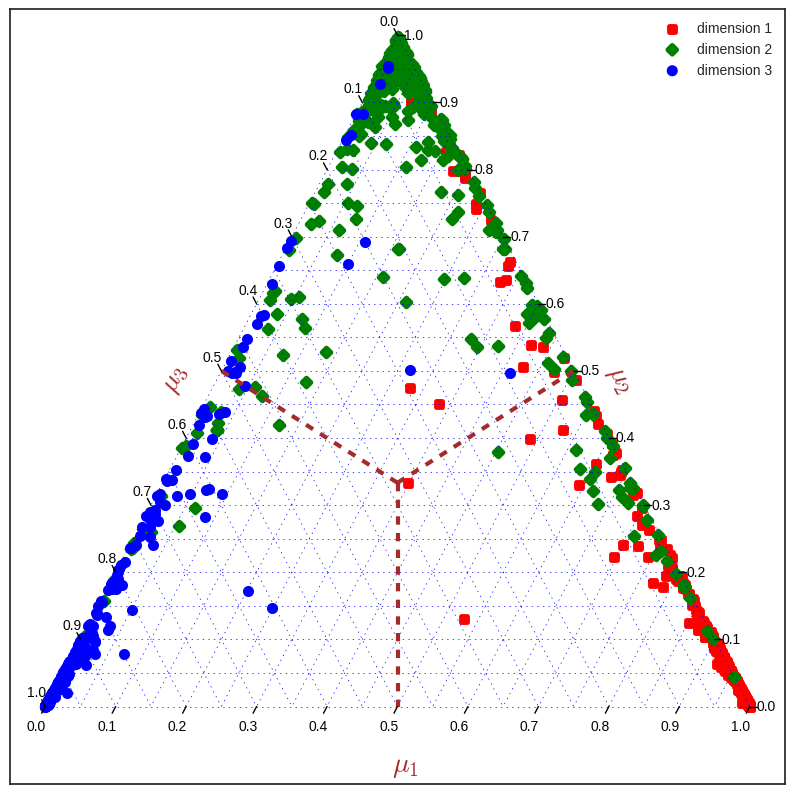

806it [00:35, 19.44it/s]


KeyboardInterrupt: 

In [46]:
figure_folder = "../figures/rooted-proba-vs-sample-roots"
for rand_state in range(1, 5):
    events, parents = model.simulate(t_max, rand_state=rand_state)
    rooted_proba = model.eval_rooted_proba(events)
    roots = model.eval_roots([e[1] + 1 for e in events], parents)    
      
    fig, ax = plot_ternary(rooted_proba, np.array(roots))
    # ax.legend(['root 1', 'root 2', 'root 3'])
    fig.savefig('%s/model1-rand%d.eps' % (figure_folder, rand_state))

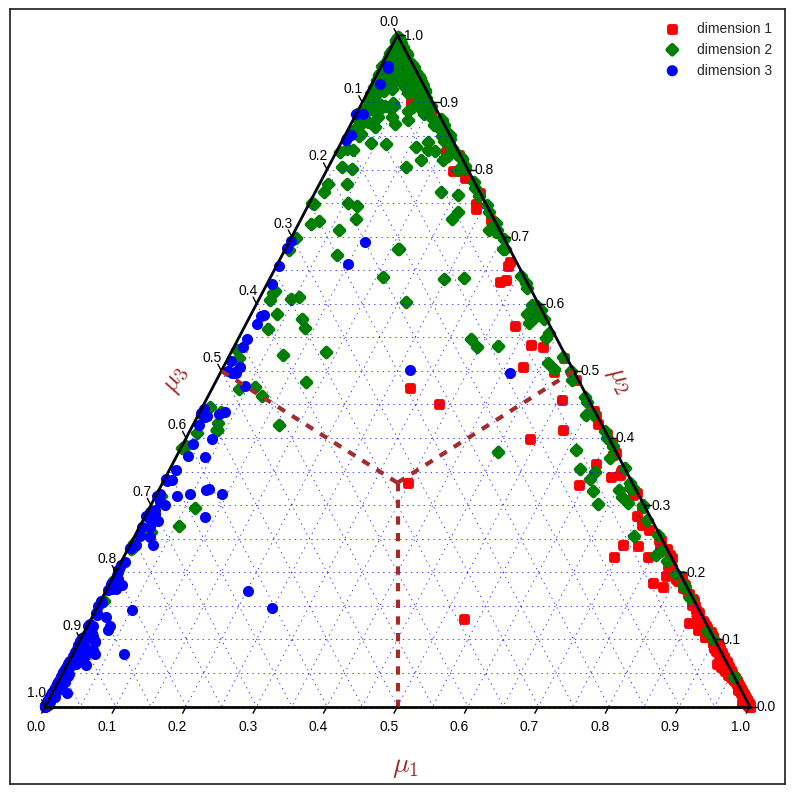

AttributeError: 'TernaryAxesSubplot' object has no attribute 'patch'

In [52]:
fig, ax = plot_ternary(rooted_proba, np.array(roots))
ax.patch.set_visible(False)
fig.savefig('%s/model1-rand%d.eps' % (figure_folder, rand_state))

## Case study: rand_state=3 

In [21]:
events, parents = model.simulate(t_max, rand_state=3)
rooted_proba = model.eval_rooted_proba(events)
df = construct_dataframe(events, parents)
df['rp1'] = rooted_proba[:, 0]
df['rp2'] = rooted_proba[:, 1]
df['rp3'] = rooted_proba[:, 2]
df['r'] = model.eval_roots(df.i, df.z)
df['rhat'] = np.argmax(rooted_proba, axis=1)
df.head()

1272it [01:02, 20.94it/s]


t  i        x1        x2  z           rp1       rp2       rp3  r  \
0   3.437654  1 -0.460042 -0.057921  0  0.000000e+00  1.000000  0.000000  1   
1   5.948464  1 -0.545360 -1.546477  0  0.000000e+00  1.000000  0.000000  1   
2   8.779277  0 -2.534630 -3.326889  0  9.940050e-01  0.005995  0.000000  0   
3   9.563336  2  0.755877  1.373583  0  1.677943e-08  0.024975  0.975025  2   
4  11.568813  1 -0.989612 -0.965051  0  2.356474e-03  0.995745  0.001898  1   

   rhat  
0     1  
1     1  
2     0  
3     2  
4     1

In [22]:
confusion_matrix(df.r, df.rhat)

array([[413,  23,   0],
       [ 31, 355,  32],
       [  0,  27, 391]])

In [23]:
def plot_sample(x, y, indices, roots, plot_parents=False):
    df = pd.DataFrame()
    df['x'] = x
    df['y'] = y
    df['i'] = indices
    df['r'] = roots
    
    colors = 'ryb'
    markers = 'sDo'
    
    for r in range(n_dimensions):
        for i in range(n_dimensions):    
            df1 = df.query("i == {} and r == {}".format(i, r))
            plt.scatter(df1.x, df1.y, 
                        c=colors[r], marker=markers[i],
                        label="root {}, dimension {}".format(r, i))
    if plot_parents:
        for k in range(len(df1)):
            z = df.ix[k, 'z']
            if z != 0:        
                x1, x2 = df.ix[z - 1, ['x1', 'x2']]
                y1, y2 = df.ix[k, ['x1', 'x2']]
                plt.arrow(x1, x2, y1 - x1, y2 - x2,  
                          length_includes_head=True,
                          head_width=0.15, head_length=0.15)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

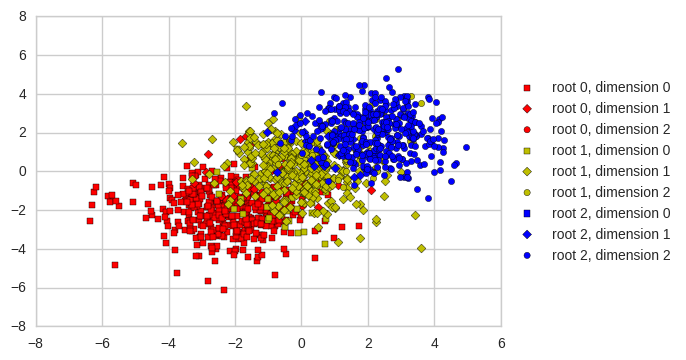

In [24]:
plot_sample(df.x1, df.x2, df.rhat, df.r)